<img src="imagenes/rn3.png" width="200">
<img src="http://www.identidadbuho.uson.mx/assets/letragrama-rgb-150.jpg" width="200">

# [Curso de Redes Neuronales](https://curso-redes-neuronales-unison.github.io/Temario/)

# Redes neuronales hacia adelante

[**Julio Waissman Vilanova**](http://mat.uson.mx/~juliowaissman/), 22 de febrero de 2018.

En esta libreta vamos a practicar con el algoritmo básico para realizar reconocimiento en redes neuronales hacia adelante y establecer una estructura básica para simular cn fines de comprensión. Para aplicaciones reales vamos a utilizar herramientas poderosas como [Tensorflow](https://www.tensorflow.org), pero es importante hacer una primer red neuronal simple a pie con el objetivo de entender mejor los mecanismos básicos.

Como dijo Jack el destripador, vamos por partes, y empecemos con asumir que tenemos la especificación completa de la red neuronal y lo que queremos es poder generar una red neuronal inicial, o poder recuperar una red existente previamente guardada.

Empecemos por inicializar los modulos que vamos a requerir.

In [1]:
import numpy as np
import _pickle as cPickle

## 1. Especificando una red neuronal

Primero, para poder hacer una red neuronal, tenemos que determinar cierta información. La información importante que debemos de especificar cuando hacemos una redes neuronales es:

- Cuantas capas de neuronas tiene la red neuronal, $L$.
- Cuantas neuronas va a tener cada capa $[n_0, n_1, \ldots, n_L]$, donde $n_0$ es el número de entradas y $n_L$ el número de salidas.
- Cual es la función de activación de las neuronas ocultas (logística, lineal rectificada, ...).
- Cual es el tipo de salida de mi red neuronal (lineal, logística, unidad softmax, ... ).
- Los valores con los que se normalizan los datos de entrada a la red neuronal (para el aprendizaje en una red neuronal es muy importante que los valores de entrada estén normalizados).

Una vez que se establecen estos valores, es necesario generar una lista de matrices $[W^{(1)}, \ldots, W^{(L)}]$ donde $W^{(l)}$ es una matriz de dimensiones $(n_l, n_{l-1})$ de pesos. Igualmente es necesario generar una lista de vectores $[b^{(1)}, \ldots, b^{(L)}]$ donde $b^{(l)}$ es un vector de $n_l$ elementos llamados sesgos.

Si se inicializan los valores de las entradas de $W^{(l)}$ y $b^{(l)}$ iguales, es equivalente a tener una sola neurona en esa capa, por lo que es necesario que estos valores sean diferentes. Para este ejemplo y con el fin de simplificar las operaciones de aprendizaje más adelante, vamos a asumir que la función de activación siempre será la función logística.

Para efectos de un mejor aprendizaje, y asumiendo que la función de activación es la logistica, es importante que los valores iniciales de los pesos se encuentren en la zona donde casuan más variacion la función logística. Si asumimos que las entradas a cada neurona están normalizadas (esto es, entre 0 y 1), entonces los pesos deberían ser valores entre $(-\sqrt{n_{l-1}}, \sqrt{n_{l-1}})$ con el fin que la suma se encuentre en la región donde más cambios ocurren en la función logística. 

Vamos a generar y guardar esta información en un diccionario (junto con el resto de la información que requeriramos para tener una red neuronal completamente definida. Al principio los valores de normalización no cuentan ya que estos se deben inicializar al comienzo del aprendizaje. Fijate bien que naturalmente la red neuronal se debería programar como una clase, pero para evitar complejidad que no podamos mantener en TensoFlow vamos a dejarlo todo el código en forma estructurada (solo para dejar constancia).

**Completa el código para inicializar la red neuronal**

In [2]:
def inicializa_red_neuronal(capas, tipo):
    """
    Inicializa una red neuronal como un diccionario de datos. 
    Se asume en este caso que la función de activación es la función logística
    
    Parámetros
    ----------
    neuronas_por_capa: Una lista de enteros donde el primer elemento es el número de entradas
                       y el último el número de salidas, mientras que los intermedios son
                       el númerode neuronas en cada capa oculta.
    tipo: Un string entre {'lineal', 'logistica', 'softmax'} con el tipo de función de salida de la red.
    
    Devuelve
    --------
    Un diccionario `rn` tal que
        - rn['capas'] = [n0, n1, ..., nL] neuronas por capa
        - rn['tipo'] = tipo
        - rn['W'] = [None, W1, ..., WL] lista de matrices de pesos
        - rn['b'] = [None, b1, ..., bL] lista de sesgos
        - rn['mu'] = lista de medias de cada atributo (se inicializan con puros 0)
        - rn['std'] = lista de desviaciones estandard de cada atributo (se inicializan con puros 1)
             
    """
    rn = {'capas': len(capas), 'tipo': tipo}
    rn['mu'] = np.zeros(capas[0])
    rn['std'] = np.ones(capas[0])    
    rn['W'], rn['b'] = inicializa_Wb(capas)
    return rn

def inicializa_Wb(capas):
    """
    Inicializa una matriz de valores aleatorios W
    
    Parámetros
    ----------
    capas: [n0, n1, ..., nL] número de neuronas por capa
    
    Devuelve
    --------
    W, b donde W = [None, W1, ..., WL] y b = [None, b1, ..., bL]              
    
    """
    W = [None] + [ np.random.rand(capas[nl], capas[nl-1]) for nl in range(1, len(capas))]
    b = [None] + [ np.random.rand(capas[nl]) for nl in range(1, len(capas))]
    
    return W, b


def test_inicializaWb():
    #Vamos a hacer 1000 pruebas aleatorias que nos aseguremos que se cumpleen con las especificaciones
    for _ in range(1000):
        n = [np.random.randint(1, 20) for _ in range(5)]
        W, b = inicializa_Wb(n)
        assert len(W) == len(b) == len(n)
        for l in range(1, 5):
            assert W[l].shape == (n[l], n[l - 1])    # Las dimensiones son correctas
            assert W[l].max() < np.sqrt(n[l - 1])    # La cota máxima se respeta
            assert W[l].min() > -np.sqrt(n[l - 1])   # La cota mínima se respeta
            assert np.abs(W[l]).sum() > 0            # No estamos inicializando a 0
    return "Paso la prueba"

print(test_inicializaWb())

Paso la prueba


Como entrenar una red es algo lento y tedioso, y normalmente cuando hacemos un método de aprendizaje, lo que queremos es poder utilizarlo después para predecir un conjunto de datos no etiquetados previamente, es normal que guardemos en un archivo la información específica a la red neuronal, y despues la recuperemos en otra sesión, otro día, o en otra computadora para hacer la predicción.

Una manera de guardar datos, funciones y objectos de Python en disco es utilizando el módulo ``pickle`` (o su versión compilada para mayor velocidad ``cPickle``). Este modulo permite guardar una serie de objetos de python en forma serializada en un archivo binario, y luego recuperarlos. Notese que este método es diferente a ``np.load`` y ``np.savez``, ya que estos solo permiten guardar (y recuperar) una serie de ndarrays únicamente. 

Vamos entonces a hacer dos funciones muy simples ``guarda_objeto`` y ``carga_objeto``, que utilizaremos más adelante.

In [3]:
def guarda_objeto(archivo, objeto):
    """
    Guarda un objeto de python en el archivo "archivo". Si el archivo existe, sera reemplazado sin 
    preguntas, al puro estilo mafioso.
    
    Parámetros
    ----------
    archivo: string con el nombre de un archivo (aunque no exista)
    objeto: Un objeto de python para ser guardado
    
    """
    
    with open(archivo, 'wb') as arch:
        cPickle.dump(objeto, arch, -1)
        arch.close()
        
def carga_objeto(archivo):
    """
    Carga el primer (y se asume que único) objeto contenido en el archivo 'archivo' que debe de ser tipo cPickle.
    
    Parámetros
    ----------
    archivo: string con el nombre de un archivo tipo pickle
    
    Devuelve
    --------
    El primer objeto dentro del picke
    
    """
    with open(archivo, 'rb') as arch:
        objeto = cPickle.load(arch)
        arch.close()
        return objeto
    
def test_archivo():
    """
    Prueba, para esto vamos a cargar o a leer (o ambas cosas) un objeto en un archivo
    
    Por favor, borrar el archivo cada vez que se pruebe, o para probar la lectura y la escritura
    
    """
    temp = [range(100), 'prueba', True]
    guarda_objeto('prueba.pkl', temp)
    temp =[10, 'no prueba', False]
    otro = carga_objeto('prueba.pkl')
    assert len(otro[0]) == 100
    assert otro[1] == 'prueba'
    assert otro[-1]
    
    return "Pasa la prueba"

print(test_archivo())

Pasa la prueba


## 2. Calculando la salida de una red neuronal con *feedforward*


Asumamos que tenemos una red neuronal ya inicializada, y que la vamos a utilizar para calcular el costo de una solución. Como vimos en clase, el costo de la solución depende del tipo de neuronas de salida (que son en realidad la etapa de clasificación). Así, para calcular el costo, es necesario calcular la salida de la red neuronal.

Recordemos que el algoritmo para realizar la alimentación hacia adelante de una red neuronal el algoritmo es el siguiente:

1. Normaliza los valores de entrada $X_{norm}$

1. Inicializa $a^{(0)} \leftarrow X_{norm}^T$

2. Por cada capa $l$ de 1 a $L-1$:

    1. Se calcula el valor de $z^{(l)} \leftarrow W^{(l)} a^{(l-1)} + b^{(l)}$ 
       
    2. Se calcula $a^{(l)} \leftarrow g(z^{(l)})$ donde $g$ es la función de activación (en nuestro caso hemos 
       decidido utilizar la función logística, pero podríamos tener otras funciones de activación).

3. Se calcula $z^{(L)} \leftarrow W^{(L)} a^{(L-1)} + b^{(L)}$ 

4. Se calcula $a^{(L)}$ de acuerdo a la función de activación dependiendo del tipo de salida:

    * Si `tipo = 'logistica'` entonces $a^{(L)} = logistica(z^{(L)})$.
    * Si `tipo = 'lineal'` entonces $a^{(L)} = z^{(L)}$.
    * Si `tipo = 'softmax'` entonces $a^{(L)} = softmax(z^{(L)}).$

5. La salida de la red es $(a^{(L)})^T$.


**Completa el código de las funciones necesarias para normalizar las entradas y calcular las salidas y la activación de la red *feedforward*. En particular toma en cuanta que en este caso la función de softmax se realiza sobre las columnas y no sobre los renglones (como en la libreta de softmax).**

In [5]:
def mu_std(x):
    """
    Obtiene las medias y las desviaciones estandar atributo a atributo.
    
    Parámetros
    ----------
    x: un ndarray de shape (M, n) con los datos

    Devuelve
    ---------
    mu, de ndarrays de shape (n,) con las medias y las desviaciones estandar respectivamente.
    
    """
    return x.mean(axis=0), x.std(axis=0)

def normaliza(x, mu, de):
    """
    Normaliza los datos x

    Parámetros
    ----------
    x: un ndarray de shape (M, n) con los datos
    mu: ndarray de shape (n,) con las medias 
    de: ndarray de shape (n,) con las desviaciones estandar
    
    Devuelve
    --------
    x_norm un ndarray de las mismas dimensiones de x pero normalizado
    
    """
    return (x - mu.reshape(1,-1)) / de.reshape(1,-1)

def logistica(z):
    """
    Calcula la función logística para cada elemento de z
    
    Parámetros
    ----------
    z: un ndarray
    
    Devuelve
    ---------
    Un ndarray de las mismas dimensiones que z
    
    """
    return 1 / (1 + np.exp(-z))
    
def softmax(z):
    """
    Calculo de la regresión softmax
    
    Parámetros
    ----------
    z: ndarray de dimensión (K, M) donde z[:, i] es el vector de aportes lineales 
       a cada clase del objeto o situación i-ésima

    Devuelve
    --------
    Un ndarray de dimensión (K, M) donde cada columna es el calculo softmax 
    de su respectivo vector de entrada.
    
    """
    def s(x):
        aux = x - np.max(x)
        exp_aux = np.exp(aux)
        return exp_aux / np.sum(exp_aux)
    
    return np.array(list(map(s,z.T))).T

def prueba_salidas():
    # Para la logística
    z = np.array([-10, 0, 10, 0.5])
    a = logistica(z)
    assert 0 < a[0] < 0.01
    assert 0.49 < a[1] < 0.51
    assert 1 > a[2] > 0.99
    assert 0.621 < a[3] < 0.623
    # Para softmax
    z = np.random.rand(4, 20)
    a = softmax(z)
    cum = a.sum(axis=0)
    assert z.shape == a.shape
    assert cum.shape == (20, )
    assert np.all(cum > 0.999)
    assert np.all(cum < 1.001)
    
    z = np.array([[2,      1, -1000],
                  [2,    -30,   -10],
                  [2, -10000, 20000]])
    a = softmax(z)
    assert a[0, 0] == a[1, 0] == a[2, 0]
    assert a[0, 1] > 0.99
    assert a[0, 1] + a[1, 1] + a[2, 1] < 1.001
    assert a[2, 2] > 0.99
    assert a[0, 2] + a[1, 2] + a[2, 2] < 1.001
    
    return "Paso la prueba"

print(prueba_salidas())

Paso la prueba


**Y ahora hay que programar el método de alimentación hacia adelante**.

In [6]:
def f_prop(X, red_neuronal):
    """
    Calcula las activaciones en todas las capas para los valores de `X` utilizando red_neuronal.
    
    A partir de aqui se puede obtener la salida como A[-1].T (las activaciones de la última capa, transpuestas)
    
    Parámetros
    ----------
    X: ndarray de shape (M, n) donde M es el número de ejemplos y n el número de atributos
    red_neuronal: Estructura de datos de una red neuronal inicializada con la función `inicializa_red_neuronal``
    
    Devuelve
    --------
    A = [A0, A1, ..., AL] una lista de activaciones por capa, donde A[l] es una matriz de
        activaciones con forma (nl, M) donde nl es el número de neuronas de la capa l.
             
    """    
    def g(z, tipo):
        if tipo is 'lineal':
            return z
        elif tipo is 'logistica':
            return logistica(z)
        else:
            return softmax(z)
    # Inicializar A = [A0], donde A0 son las activaciones de la capa de entrada
    
    A0 = X.T
    #-------------------------------------------------
    A = [A0]
    
    # Despues vamos a hacer lo propio por cada capa hasta antes de la última
    for (Wl, bl) in zip(red_neuronal['W'][1:-1], red_neuronal['b'][1:-1]):         
        z = ((Wl @ A[-1]).T + bl).T
        Al = logistica(z)
        #-------------------------------------------------
        A.append(Al)
    # Calcula A^{L} y agrega a A de acuerdo al tipo de salida
    z = ((red_neuronal['W'][-1] @ A[-1]).T + red_neuronal['b'][-1]).T
    
    AL = g(z, red_neuronal['tipo']) # <--- De acuerdo al tipo de salida
    #-------------------------------------------------        
    A.append(AL)
    return A
    
def prueba_feedforward():
    """
    Función para validar la función de fedforward 
    
    Se inicializa una red de dos capas (más capa de entrada) y se 
    imponen los pesos. Esto se hizo a mano para las diferentes
    entradas, así que se espera que la función de feedforward de
    cosas similares

    """
    # Inicializa red neuronal
    rn = inicializa_red_neuronal([2, 2, 1], 'lineal')
    
    # Modificamos pesos y los sesgos
    rn['W'][1] = np.array([[-0.3, -0.7],
                           [0.2, 0.3]])
    rn['W'][2] = np.array([[0.5, -0.5]])
    
    rn['b'][1] = np.array([0.5, -1])
    rn['b'][2] = np.array([0])
    
    #Ponemos algunas entradas sencillas
    x = np.array([[0,   0],
                  [1,   1],
                  [-1, -1]])
    
    # Y el valor de A calculado a mano
    A1 = np.array([[0.6225, 0.3775, 0.8176],
                   [0.2689, 0.3775, 0.1824]])
    A2 = np.array([0.17676, 0, 0.3176])
    
    A = f_prop(x, rn)
    assert np.sum(np.abs(A[1] - A1)) <= 0.001
    assert np.sum(np.abs(A[2] - A2)) <= 0.001
    
    #Ahora vamos a ver que pasa si cambiamos la salida
    rn['tipo'] = 'logistica'
    A = f_prop(x, rn)
    A2 = np.array([0.544075, 0.5, 0.5787])

    assert np.sum(np.abs(A[2] - A2)) <= 0.001
    
    return "Paso la prueba"

print(prueba_feedforward())

Paso la prueba


## 3. Calcula una función símple de pérdida de una red neuronal

Con  la función de feedforward desarrollada, podemos retomar las funciones desarrolladas en las libretas anteriores para calcular la función de pérdida, dependiendo del tipo de salida.

#### Ejercicio 3: Completa el código de la función de perdida de acuerdo a las 3 salidas posibles de la red neuronal.

In [8]:
def perdida_red(X, Y, rn):
    """
    Calcula la función de perdida de una red neuronal, de acuerdo al tipo de salida
    y a un conjunto de datos conocidos expresados por Y y X

    Parámetros
    ----------
    X: un ndarray de dimension (T, N) con los valores de entrada
    Y: un ndarray de dimension (T, K) con los valores de salida
    rn: una red neuronal

    Devuelve
    --------
    Un flotante con el valor de la función de Loss
    
    """
    Y_est = f_prop(X, rn)[-1].T
    return Loss(Y, Y_est, rn['tipo'])

def Loss(Y, Y_est, tipo):
    """
    Calcula la función de perdida de una red neuronal, de acuerdo al tipo de salida 

    Parámetros
    ----------
    Y: un ndarray de dimension (M, K) con los objetivos o salidas esperadas
    Y_est: un ndarray de dimension (M, K) con los valores de salida de la red neuronal
    tipo: Un string que puede ser 'lineal', 'logistica'o 'softmax'

    Devuelve
    --------
    Un flotante con el valor de la función de Loss
    
    """
    M, K = Y.shape
    
    if tipo is 'lineal':
        return np.square(Y - Y_est).sum() / (2*M)
    elif tipo is 'logistica':
        return - (np.sum(Y * np.log(Y_est) + (1 - Y) * np.log(1-Y_est))) / M
    else:
        return - np.log(Y_est[Y==1]).sum() / M
    
def prueba_perdida():
    """
    La unidad de prueba de la función costo
    
    """
    Y = np.array([[.1, 2.2, 3.6, 0]]).T
    Y_est = np.array([[.3, 2.0, 3.8, -0.2]]).T
    assert abs(Loss(Y, Y_est, 'lineal') - 0.02) < 1e-8
    
    Y = np.array([[1, 0, 1, 0]]).T
    Y_est = np.array([[.9, 0.1, 0.8, 0.2]]).T
    assert abs(Loss(Y, Y_est, 'logistica') - 0.164252033486018) < 1e-8
    
    Y = np.array([[1, 0, 1, 0], 
                  [0, 1, 0, 0], 
                  [0, 0, 0, 1]]).T
    Y_est = np.array([[0.8, 0.1, 0.1], 
                      [0.15, 0.8, 0.05],
                      [0.9, 0.05, 0.05],
                      [0.021, 0.079, 0.9]])
    assert abs(Loss(Y, Y_est, 'softmax') - 0.164252033486018) < 1e-8
    assert abs(Loss(Y, Y_est, 'lineal') - 0.01958525) < 1e-8
    
    return 'paso la prueba'

print(prueba_perdida())

paso la prueba


## 4. El algortmo de *backpropagation*

La derivada parcial de la función de pérdida respecto a cada uno de los pesos (por lo tanto el gradiente de la función de pérdida) se obtiene mediante el algoritmo de backpropagarion. Una vez que se conoce esto, entonces es posible utilizar el resultado para entrenar la red neuronal mediente el método de descenso de gradiente o una variente.

Sea $CA = \{(x^{(1), y^{(1)}), \ldots, (x^{(M), y^{(M)})} el conjunto de datos de entrenamiento. El algoritmo de *backpropagation* es el siguiente:

1. Calcular el vector $\delta^{(L)}$ para todos los datos a partir de $A^{L}$ y $Y$, y el tipo de salida. Si utilizamos la función de pérdida correcta para cada tipo de salida, entonces esto se calcula en forma muy sencilla, tal como vimos en clases $$\delta^{(L)} = Y^T - A^{(L)}.$$

2. Para $l$ de $L-1$ hasta 1 con decrementos de $-1$:
    1. Calcular $\delta^{(l)}$ a partir de $\delta^{(l+1)}$, $W^{(l+1)}$ y $A^{(l)}$ como
       $$
       \delta^{(l)} = A^{(l)} \star (\vec{1} - A^{(l)}) \star ((W^{(l+1)})^T \delta^{(l+1)}), 
       $$
       donde $\star$ es la multiplicación elemento a elemento de dos matrices y $\vec(1)$ es una matriz con 1 en todos sus elementos.
    2. Calcular la derivada en cada uno de los pesos como
       $$
       \frac{\partial Loss(W, b)}{\partial w_{ij}^{(l)}} = \frac{1}{M}\sum_{\forall (x,y) \in CA} a_j^{(l-1)} \delta_i^{(l)},
       $$
       y
       $$
       \frac{\partial Loss(W), b}{\partial b_{i}^{(l)}} = \frac{1}{M}\sum_{\forall (x,y) \in CA} \delta_i^{(l)},       
       $$
       
El desarrollo del algoritmo y los pasos en forma matricial se vieron con detalle en clase, por lo que aqui solo se da un pequeñño bosquejo esperando que se programe correctamente.

**Completa el código de la función de backpropagation.**



In [10]:
def b_prop(Y, A, rn):
    """
    Calcula el gradiente de los pesos de una red neuronal
    
    Parametros
    -----------
    Y: ndarray de shape (M, K) donde M es el número de ejemplos y K el número de salidas
    
    A: Una lista de matrices de activaciones por capas, obtenidas por la función `f_prop`,
       en donde A[l] es un ndarray de shape (nl, M), donde M es el número de ejemplos evaluados 
       y nl es el número de neuronas de la capa l de rn.

    rn: Estructura de datos de una red neuronal inicializada con la función 
        `inicializa_red_neuronal`
    
    Devuelve
    --------
    gW, gb, tales que: 
        gW = [None, gW1, ..., gWL], donde cada gWl es un ndarray tal que 
             rn['W'][l].shape == gWl.shape 
        gb = [None, gb1, ..., gbL] ta que rn['b'][l].shape == wb[l],
             con las derivadas parciales calculadas para cada parámetro.
             
    """    
    # Numero de ejemplos
    M, K = Y.shape
    gW, gb = [], []

    # Calcula delta, gW_L y gb_l para la capa de salida
    delta = -(Y.T - A[-1])
    gW_L = delta @ A[-2].T / M
    gb_L = delta.mean(axis=1)
    
    # Agrega a la lista
    gW.append(gW_L)
    gb.append(gb_L)
    
    # Después vamos a hacer lo propio por cada capa hasta antes de la última
    for l in range(rn['capas'] - 2, 0, -1):         
        # Calcula la delta, gW_l y gb_l para la capa anterior.        
        delta = A[l] * (1 - A[l]) * (rn['W'][l+1].T @ delta)
        gW_l = delta @ A[l-1].T / M
        gb_l = delta.mean(axis=1)
        # ------------------------------------------------
        gW.append(gW_l)
        gb.append(gb_l)
    gW.reverse()
    gb.reverse()
    gW = [None] + gW
    gb = [None] + gb        
    return gW, gb

## 5. Revisar y corregir código de aprendizaje máquina

El problema con este tipo de algoritmos es que, a la hora de codificarlos, es muy típico que se tengan errores, tanto de concepto como de codificación. Sin embargo, como estos algortimos se utilizan para aprender, y al utilizar un conjunto inicial de pesos aleatorio diferente, los resultados no son verificables. Es muy común tener un error muy tonto y pasar muchas horas (o días) intentando corregirlo.

Por esta razón, siempre hay que hacer métodos que nos permitan chacar que el algortimo parece funcionar correctamente. Para eso, vamos a programar una forma alternativa de calcular una aproximación del gradiente en forma numérica. Este algortimo de fuerza bruta es altamente ineficiente y no puede ser utilizada dentro de un método de optimización pero nos sirve para revisar si existen errores que podríamos haber ingresado en nuestro algoritmo.

El método se basa en el calculo numérico de una derivada parcial como:

$$
  \left.\frac{\partial f(x)}{\partial x}\right|_{x = x_0} \approx \frac{f(x_0 + \epsilon) - f(x_0 - \epsilon)}{2 \epsilon}.  
$$

Entonces, si queremos estimar el gradiente de la función de pérdida respecto a los pesos, hay que calcular esta razón por cada uno de los pesos, por cada una de las capas. Esto no es nada eficiente y mucho menos elegante (como el *b-prop*) pero es un método de validación.

**Completa el código de la función de gradiente numérico.**

In [11]:
def gradiente_numerico(X, Y, rn, epsilon=1e-3):
    """
    Calcula el gradiente numérico para efectos de prueba del algoritmo de backpropagation.
    Este algortimo se realiza expresamente de manera ineficiente pero clara, ya que su
    funcionamiento debe de ser lo más claro posible.
    
    Parámetros
    ----------
    X: ndarray de shape (M, n) donde M es el número de ejemplos y n el número de atributos
    Y: ndarray de shape (M, K) donde K es el número de salidas
    rn: Estructura de datos de una red neuronal inicializada con la función `inicializa_red_neuronal``
    epsilon: Un número flotante positivo, típicamente muy pequeño
 
    Devuelve
    --------
    gW, gb, tales que: 
        gW = [None, gW1, ..., gWL], donde cada gWl es un ndarray tal que 
             rn['W'][l].shape == gWl.shape 
        gb = [None, gb1, ..., gbL] ta que rn['b'][l].shape == wb[l],
             con las derivadas parciales calculadas para cada parámetro.

    """
    # inicializa gW y gB
    gW = [None] + [np.ones_like(Wl) for Wl in rn['W'][1:]]
    gb = [None] + [np.ones_like(bl) for bl in rn['b'][1:]]
    
    for l in range(1,rn['capas']):                #  Por cada capa l
        for i in range(rn['W'][l].shape[0]):          #  Por cada renglon i
            for j in range(rn['W'][l].shape[1]):      #  Por cada columna j
                w_aux = rn['W'][l][i][j]
    
                rn['W'][l][i][j] += epsilon
                pp = Loss(Y, f_prop(X,rn)[-1].T, rn['tipo'])
    
                rn['W'][l][i][j] -= 2 * epsilon
                pa = Loss(Y, f_prop(X,rn)[-1].T, rn['tipo'])
                
                gW[l][i][j] = (pp - pa) / (2 * epsilon)
                rn['W'][l][i][j] = w_aux
                
            b_aux = rn['b'][l][i]
            
            rn['b'][l][i] += epsilon
            pp = Loss(Y, f_prop(X,rn)[-1].T, rn['tipo'])
            
            rn['b'][l][i] -= 2 * epsilon
            pa = Loss(Y, f_prop(X,rn)[-1].T, rn['tipo'])
            
            gb[l][i] = (pp - pa) / (2 * epsilon)
            rn['b'][l][i] = b_aux
                
    return gW, gb           

Ahora vamos a hacer una función de prueba utilizando un conjunto de datos reales (o un subconjunto de estos), y lo vamos a hacer para muchas posibles reinicializaciones de pesos. Este código va a servir para corregir ambos algoritmos de calculo de gradiente.  Para esto vamos a utilizar una base de datos ya conocida, la de dígitos, utilizada en la libreta de regresión softmax.

In [12]:
# Datos a utilizar para la prueba
# para no tener que estarlos cargando de nuevo cada vez

# Vamos a utilizar un subconkunto de datos y de atributos
# para que pueda funcionar el gradiente numérico en un tiempo 
# aceptable
data = np.load("datos/digitos.npz")
x_prueba = data['X_entrena'][:100,:10]  # Solo 100 datos y 10 parámetros
y_prueba = data['T_entrena'][:100,:]    # Todas las clases de los primeros 100 datos

No seguir más allá en la programación de la red neuronal hasta estar seguro que esto funcione correctamente.

In [13]:
def prueba_gradiente(X, Y):
    """
    Unidad de prueba de backpropagation
    
    """
    n0 = X.shape[1]
    nL = Y.shape[1]
    
    for ocultas in [2, 3]: 
        for neuronas in [2, 3]:
            rn = inicializa_red_neuronal([n0] + (ocultas * [neuronas * n0]) + [nL],
                                         'lineal')

            for tipo in ['logistica', 'softmax', 'lineal']:
                rn['tipo'] = tipo
                A = f_prop(X, rn)
                gW, gb = b_prop(Y, A, rn)
                gWn, gbn = gradiente_numerico(X, Y, rn, 1e-3)
                
                diferenciasW = [np.abs(gwl - gwln).max() 
                                for (gwl, gwln) in zip(gW[1:], gWn[1:])]
                diferenciasb = [np.abs(bl - bln).max() 
                                for (bl, bln) in zip(gb[1:], gbn[1:])]

                print("Tipo: {}, Neuronas: {}".format(rn['tipo'], rn['capas']))
                print("Máxima diferencia entre métodos de gradiente para w: {}".format(max(diferenciasW)))
                print("Máxima diferencia entre métodos de gradiente para b: {}".format(max(diferenciasb)))
                if max(diferenciasW) > 1e-3:
                    print(gW[-1])
                    print(gWn[-1])
                assert max(diferenciasW) < 1e-3
                assert max(diferenciasb) < 1e-3
    return "Paso la prueba"

print(prueba_gradiente(x_prueba, y_prueba))

Tipo: logistica, Neuronas: 4
Máxima diferencia entre métodos de gradiente para w: 3.940441277569193e-08
Máxima diferencia entre métodos de gradiente para b: 2.9122985923443062e-08
Tipo: softmax, Neuronas: 4
Máxima diferencia entre métodos de gradiente para w: 1.494599440043931e-08
Máxima diferencia entre métodos de gradiente para b: 1.4954282562262833e-08
Tipo: lineal, Neuronas: 4
Máxima diferencia entre métodos de gradiente para w: 1.603589316889753e-08
Máxima diferencia entre métodos de gradiente para b: 4.198595671134342e-08
Tipo: logistica, Neuronas: 4
Máxima diferencia entre métodos de gradiente para w: 1.6024083491635678e-06
Máxima diferencia entre métodos de gradiente para b: 1.49553141679765e-06
Tipo: softmax, Neuronas: 4
Máxima diferencia entre métodos de gradiente para w: 1.554880207921272e-08
Máxima diferencia entre métodos de gradiente para b: 1.5548490911454493e-08
Tipo: lineal, Neuronas: 4
Máxima diferencia entre métodos de gradiente para w: 3.576561949381052e-09
Máxima d

## 6. El algoritmo de descenso de gradiente 

Ya que estamos seguros que el método de *b-prop* funciona correctamente, entonces ya podemos poner todo junto muy fácilmente para realizar aprendizaje. Para esto vamos a utilizar el método de descenso de gradiente, el cual, en su forma más simple por lotes no es más que repetir por un número de veces (*epochs*) el calculo del gradiente y modificar los pesos de la red en dirección contraria a estos. 

En forma de algoritmo esto sería realizar los siguientes pasos:

1. De 1 a `max_epochs`:
    1. Calcular las activaciones `A` con el algoritmo de *feedforward*
    2. Calcular los gradientes $\nabla_W^{(l)}Loss(W, b)$ y $\nabla_b^{(l)}Loss(W, b)$ para toda capa $l$, con el algoritmo de *backpropagation*.
    3. Actualizar los pesos como
       $$
       W^{(l)} \leftarrow W^{(l)} - \alpha \nabla_W^{(l)}Loss(W, b),\\ 
       b^{(l)} \leftarrow b^{(l)} - \alpha \nabla_b^{(l)}Loss(W, b).
       $$
       
Como vemos, en este algoritmo solo hay que especificar dos variables, la tasa de aprendizaje $\alpha$ y el número máximo de *epochs*. Este algoritmo solo lo ponemos como una primera aproximación, pero es un método de base del cual partiremos para realizar mejores algoritmos de aprendizaje.

**Completa el código de la función de descenso de gradiente.**

In [14]:
def desc_grad(X, Y, rn, alfa=0.2, max_epochs=1000):
    """
    Entrena una red neuronal utilizando el método de descenso de gradiente simple
    
    Parámetros
    ----------
    X: ndarray de shape (M, n) donde M es el número de ejemplos y n el número de atributos
    Y: ndarray de shape (M, K) donde K es el número de salidas
    rn: Estructura de datos de una red neuronal inicializada con la función `inicializa_red_neuronal``
    alfa: La tasa de aprendizaje, un número flotante positivo
    max_epochs: Número de epocas o iteraciones del algoritmo. Un entero positivo.
    normaliza: Un booleano para usar X y Y para normalizar o no los datos antes de entrar a la rn.
    
    Devuelve
    --------
    None, la función utiliza el hecho que rn es un objeto mutabe y modifica rn['W'] directamente.
    
    """
    # Aprendizaje
    for _ in range(max_epochs):
        # Calcula las activaciones
        A = f_prop(X, rn)
        # Calcula los gradientes
        dw , db = b_prop(Y, A, rn)
        # Actualiza los pesos
        for l in range(1, rn['capas']):
            rn['W'][l] -= alfa * np.array(dw)[l]
            rn['b'][l] -= alfa * np.array(db)[l]

Y ahora hay que probar que el algoritmo funciona para un problema sencillo que nos permita encontrar problemas en su codificación. Para esto vamos a generar un conjunto de datos de entrenamiento, los cuales los podremos visualizar fácilmente.

Text(0.5,1,'Datos sintéticos para probar el algoritmo de descenso de gradiente')

/home/raul/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


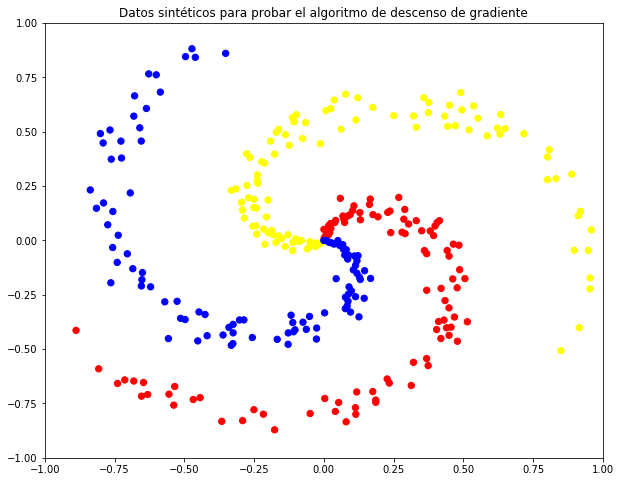

In [15]:
#  Biblioteca de graficación y configuracion de figuras
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#  Inicialización de datos
np.random.seed(0) # Aseguramos que siempre pasa lo mismo
N = 100 # Ejemplos por clase
D = 2 # Atributos
K = 3 # Clases
X = np.zeros((N * K, D))
Y = np.zeros((N * K, K), dtype='uint8')
y = []

# Genera datos en espiral
for clase in range(K):
  ix = list(range(N*clase, N*(clase+1)))  # Indices para cada clase
  r = np.linspace(0.0, 1, N) 
  t = np.linspace(clase * 4, (clase + 1) * 4, N) + np.random.randn(N) * 0.2 
  X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
  Y[ix, clase] = 1
  y.extend([['red', 'yellow', 'blue'][clase] for _ in ix])


#  Grafica datos
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title("Datos sintéticos para probar el algoritmo de descenso de gradiente")

Como podemos ver, los datos generados tienen más de dos clases y no son linealmente separables. De lo que se infiere que el algoritmo más adaptado a este problema es una red neuronal con salida *softmax* y con al menos una capa oculta (o dos). 

En un primer paso, yo voy a hacer una red tipo softmax sin capas ocultas, la cual tendría que entrenarse fácilmente y debería ser fácil de visualizar si los resultados son correctos.

In [16]:
rn = inicializa_red_neuronal([2, 3], 'softmax')

desc_grad(X, Y, rn, alfa=0.2, max_epochs=1000)

Y_est = f_prop(X, rn)[-1].T
y_est = np.argmax(Y_est, axis=1)

Y ahora vamos a visualizar los resultados a ver si tienen sentido.

Text(0.5,1,'Separación lineal de los datos sintéticos con una red neuronal sin capas ocultas')

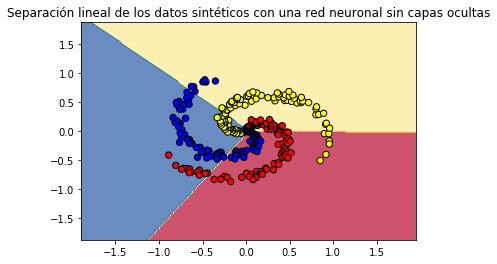

In [17]:
# Genera un grid en todo el espacio con datos a clasificar
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
X_mesh = np.c_[xx.ravel(), yy.ravel()]

# Calcula la predicción de clase para estos datos
Y_mesh = f_prop(X_mesh, rn)[-1].T
y_mesh = np.argmax(Y_mesh, axis=1)

# Ajusta las salidas en forma de matriz para graficar el contorno
y_mesh = y_mesh.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, y_mesh, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='black')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Separación lineal de los datos sintéticos con una red neuronal sin capas ocultas")

y si el programa funciona correctamente, el resultado debería ser una imagen como esta:

![Separación lineal de los datos sintéticos con una red neuronal sin capas ocultas](imagenes/espiral_linear.png)

Si este es el caso, entonces ya estamos listos para probar el algoritmo de descenso de gradiente para una red neuronal con capas ocultas.

**Realiza el aprendizaje con una red neuronal con capas ocultas, de forma que todos los datos sean correctamente clasificados y grafíca el resultado de manera similar a como se hizo para la red neuronal sin capas ocultas.**

Text(0.5,1,'Separación lineal de los datos sintéticos con una red neuronal sin capas ocultas')

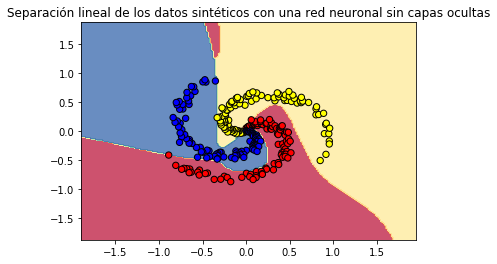

In [24]:
# Realiza el aprendizaje con una red neuronal con capas ocultas, 
# de forma que todos los datos sean correctamente clasificados 
# y grafíca el resultado de manera similar a como se hizo para 
# la red neuronal sin capas ocultas.

# El resultado debe de ser una figura similar a la 
# anterior pero que se pueda ver la partición no lineal del espacio

rn = inicializa_red_neuronal([2,5,5,3], 'softmax')

desc_grad(X, Y, rn, alfa=0.2, max_epochs=12000)

Y_est = f_prop(X, rn)[-1].T
y_est = np.argmax(Y_est, axis=1)

# Genera un grid en todo el espacio con datos a clasificar
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_mesh = np.c_[xx.ravel(), yy.ravel()]

# Calcula la predicción de clase para estos datos
Y_mesh = f_prop(X_mesh, rn)[-1].T
y_mesh = np.argmax(Y_mesh, axis=1)

# Ajusta las salidas en forma de matriz para graficar el contorno
y_mesh = y_mesh.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, y_mesh, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='black')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Separación lineal de los datos sintéticos con una red neuronal sin capas ocultas")